In [1]:
import os
os.environ["RUST_BACKTRACE"] = "1"

In [2]:
import logging
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from aqmodels import Model, Solution
from aqmodels.transformations import PassManager
from luna_quantum import Model as AqModel
from luna_quantum import algorithms
from luna_quantum.solve.interfaces.algorithm_i import IAlgorithm
from luna_quantum.solve.parameters.algorithms.quantum_gate.flex_qaoa import PipelineParams
from luna_quantum.solve.parameters.algorithms.base_params import ScipyOptimizerParams


from luna_quantum.util.log_utils import Logging
Logging.set_level(log_level=logging.NOTSET)


# Classical optimization
from scipy.optimize import minimize

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.model import optimization_model
from model.visualization import (
    plot_floor_plan,
    plot_satisfaction,
    solution_to_assignment,
)
from utils.algorithm import MyQAOA
from utils.benchmark import get_metrics
from utils.qaoa import qaoa_circ_adv

# Import utils (from last notebook)
from utils.sampling import cost_function, sample
from utils.transformations import qubo_pipeline, xy_pipeline

%load_ext dotenv
%dotenv

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

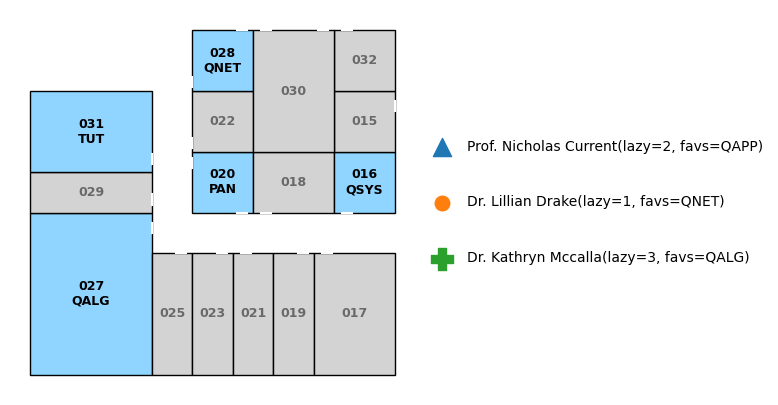

In [3]:
center = ConventionCenter.generate()
schedule = Schedule.random(5, center, seed=5)
chairs = SessionChair.random_chairs(3, seed=1)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [4]:
x, model = optimization_model(center, schedule, chairs, satisfaction=1)

In [5]:
def get_metrics(
    solution: Solution, optimal: float | None = None, circuit_depth: int | None = None
) -> dict[str, float]:
    """Computes the metrics for a given solution.

    Parameters
    ----------
    solution: Solution
        The solution output from the algorithm excecution.
    optimal: float | None
        The optimal value of the optimization problem. If none provided 'p_opt', 'p_90'
        and 'tts' cannot be computed.
    circuit_depth: float | None
        The circuit depth of the algorithm. If none provided 'tts' cannot be computed.

    Returns
    -------
    dict[str, float]
        Metrics dict, featuring 'approximation_ratio', 'best_found',
        'feasibility_ratio', 'p_opt', 'p_90' and 'tts'
    """

    # Compute feasibility ratio and approximation ratio of feasible samples
    feas = solution.feasibility_ratio()
    feasible_solutions = solution.filter_feasible()
    ar = feasible_solutions.expectation_value()

    metrics = {
        "approximation_ratio": ar,
        "feasibility_ratio": feas,
    }

    # Find best solution
    best_found = solution.best()
    if best_found is not None and best_found.obj_value is not None:
        metrics["best_found"] = best_found.obj_value

    # Compute p_opt and p_90
    total = solution.counts.sum()
    if optimal is not None:
        metrics["p_opt"] = (
            feasible_solutions.counts[
                np.isclose(feasible_solutions.obj_values, optimal)
            ].sum()
            / total
        )
        metrics["p_90"] = (
            feasible_solutions.counts[
                np.abs(feasible_solutions.obj_values - optimal) / np.abs(optimal) < 0.1
            ].sum()
            / total
        )

    # Compute TTS
    p_opt = metrics.get("p_opt", None)
    if p_opt is not None and circuit_depth is not None:
        if p_opt == 0:
            tts = np.inf
        elif p_opt == 1:
            tts = circuit_depth
        else:
            tts = circuit_depth * np.ceil(np.log(0.01) / np.log(1 - p_opt))
        metrics["tts"] = tts

    return metrics

In [6]:
reps_range = range(1, 5)
optimizer = ScipyOptimizerParams(method="COBYLA", options={"rhobeg": 0.05}, maxiter=1000)
algos = {
    "my_qaoa (xy)": MyQAOA(pass_manager=xy_pipeline, optimizer=optimizer, shots=100000),
    "my_qaoa (qubo)": MyQAOA(pass_manager=qubo_pipeline, optimizer=optimizer),
    "flex_qaoa (qubo)": algorithms.FlexQAOA(pipeline=PipelineParams(one_hot=None), optimizer=optimizer),
    "flex_qaoa (xy)": algorithms.FlexQAOA(optimizer=optimizer),
}
models = {"normal": model}

In [7]:
opt = algorithms.SCIP().run(AqModel.decode(model.encode())).result()

Output()

Output()

Output()

Output()

In [8]:
algorithms.FlexQAOA()

FlexQAOA(shots=1024, reps=1, pipeline=PipelineParams(indicator_function=IndicatorFunctionParams(penalty=None, penalty_scaling=2), one_hot=OneHotParams(), quadratic_penalty=QuadraticPenaltyParams(penalty=None)), optimizer=ScipyOptimizerParams(method='cobyla', tol=None, bounds=None, jac=None, hess=None, maxiter=100, options={}), qaoa_config=AdvancedConfig(mixer=XYMixer(types=['even', 'odd', 'last']), parallel_indicators=True, discard_slack=False, infeas_penalty=None), initial_params=LinearQAOAParams(delta_beta=0.5, delta_gamma=0.5))

In [9]:
data = []
for aname, algorithm in algos.items():
    for r in reps_range:
        algorithm.reps = r
        # print(aname)
        if isinstance(algorithm, IAlgorithm):
            # m = AqModel.decode(model.encode())
            sol = algorithm.run(AqModel.decode(model.encode())).result()
            sol = Solution.decode(sol.encode())
            circuit_depth = None
        else:
            sol = algorithm.run(model).result()
            circuit_depth = algorithm.circuit.depth()
        metrics = get_metrics(sol, opt.best().obj_value, circuit_depth)
        data.append({"name": aname, "rep": r, **metrics})

df = pd.DataFrame(data)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

<Axes: xlabel='name', ylabel='approximation_ratio'>

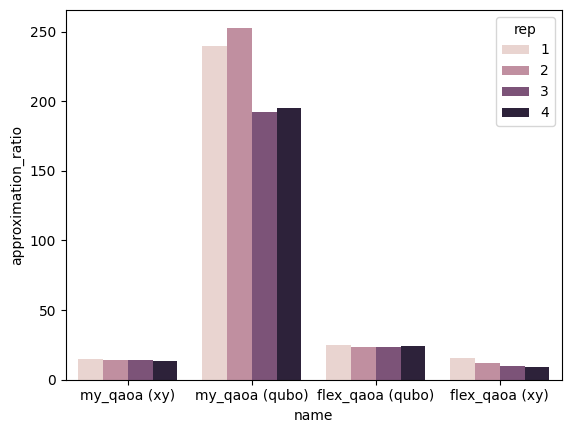

In [14]:
sns.barplot(df, x="name", y="approximation_ratio", hue="rep")
# plt.yscale("log")

In [11]:
df

,name,rep,approximation_ratio,feasibility_ratio,best_found,p_opt,p_90,tts
0,my_qaoa (xy),1,14.916024,1.000000,4.6,0.025440,0.025440,3580.0
1,my_qaoa (xy),2,14.365014,1.000000,4.6,0.027640,0.027640,5115.0
2,my_qaoa (xy),3,13.885750,1.000000,4.6,0.030870,0.030870,6174.0
3,my_qaoa (xy),4,13.517541,1.000000,4.6,0.033300,0.033300,7208.0
4,my_qaoa (qubo),1,239.431900,1.000000,4.6,0.001000,0.001000,105869.0
5,my_qaoa (qubo),2,253.024800,1.000000,4.6,0.001000,0.001000,147296.0
6,my_qaoa (qubo),3,192.413400,1.000000,4.6,0.001000,0.001000,216341.0
7,my_qaoa (qubo),4,194.867100,1.000000,4.6,0.002000,0.002000,128856.0
8,flex_qaoa (qubo),1,24.531604,0.207031,5.9,0.000000,0.000000,NaN
9,flex_qaoa (qubo),2,23.624901,0.737305,4.6,0.002930,0.002930,NaN


In [12]:
ir = xy_pipeline.run(model)



qaoa_circ_adv(ir).draw()

┌───┐              ┌───┐                                           »
    q_0: ┤ X ├──────■───────┤ X ├────────────■──────────────────────────────»
         └───┘┌─────┴──────┐└─┬─┘            │                              »
    q_1: ─────┤ Ry(1.9106) ├──■───────■──────┼──────────────────────────────»
              └────────────┘     ┌────┴────┐ │                              »
    q_2: ────────────────────────┤ Ry(π/2) ├─┼──────────────────────────────»
         ┌───┐              ┌───┐└─────────┘ │P(0.6666666666666667*gamma_0) »
    q_3: ┤ X ├──────■───────┤ X ├────────────■──────────────────────────────»
         └───┘┌─────┴──────┐└─┬─┘                        ┌───┐              »
    q_4: ─────┤ Ry(1.9106) ├──■───────■──────────────────┤ X ├──────────────»
              └────────────┘     ┌────┴────┐             └─┬─┘              »
    q_5: ────────────────────────┤ Ry(π/2) ├───────────────■────────────────»
         ┌───┐              ┌───┐└─────────┘                                »
    q_6: ┤ X ├──────■───────┤ X ├───────────────────────────────────────────»
         └───┘┌─────┴──────┐└─┬─┘                        ┌───┐              »
    q_7: ─────┤ Ry(1.9106) ├──■───────■──────────────────┤ X ├──────────────»
              └────────────┘     ┌────┴────┐             └─┬─┘              »
    q_8: ────────────────────────┤ Ry(π/2) ├───────────────■────────────────»
         ┌───┐              ┌───┐└─────────┘                                »
    q_9: ┤ X ├──────■───────┤ X ├───────────────────────────────────────────»
         └───┘┌─────┴──────┐└─┬─┘                        ┌───┐              »
   q_10: ─────┤ Ry(1.9106) ├──■───────■──────────────────┤ X ├──────────────»
              └────────────┘     ┌────┴────┐             └─┬─┘              »
   q_11: ────────────────────────┤ Ry(π/2) ├───────────────■────────────────»
         ┌───┐              ┌───┐└─────────┘                                »
   q_12: ┤ X ├──────■───────┤ X ├───────────────────────────────────────────»
         └───┘┌─────┴──────┐└─┬─┘                        ┌───┐              »
   q_13: ─────┤ Ry(1.9106) ├──■───────■──────────────────┤ X ├──────────────»
              └────────────┘     ┌────┴────┐             └─┬─┘              »
   q_14: ────────────────────────┤ Ry(π/2) ├───────────────■────────────────»
                                 └─────────┘                                »
meas: 15/═══════════════════════════════════════════════════════════════════»
                                                                            »
«                                               »
«    q_0: ──────────────────────────────────────»
«                         ┌───┐                 »
«    q_1: ────────────────┤ X ├─────────────────»
«                         └─┬─┘                 »
«    q_2: ──────────────────■───────────────────»
«                                               »
«    q_3: ──────────────────────────────────────»
«         ┌────────────────────────────────────┐»
«    q_4: ┤ P((-0.044444444444444446)*gamma_0) ├»
«         └────────────────────────────────────┘»
«    q_5: ──────────────────────────────────────»
«                                               »
«    q_6: ──────────────────────────────────────»
«                                               »
«    q_7: ──────────────────────────────────────»
«                                               »
«    q_8: ──────────────────────────────────────»
«                                               »
«    q_9: ──────────────────────────────────────»
«                                               »
«   q_10: ──────────────────────────────────────»
«                                               »
«   q_11: ──────────────────────────────────────»
«                                               »
«   q_12: ──────────────────────────────────────»
«                                               »
«   q_13: ──────────────────────────────────────»
«         ┌────────────────────────